In [1]:
import torch.nn as nn
import torchvision.models as models

import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import pandas as pd
import numpy as np

from PIL import Image
import os
from torch.utils.data import Dataset


In [2]:
full_df = pd.read_csv("../labels_train_updated.csv")
df_region = full_df[['filename', 'Region_ID']]
print(df_region.head())

       filename  Region_ID
0  img_0000.jpg          2
1  img_0001.jpg          2
2  img_0002.jpg          2
3  img_0003.jpg          2
4  img_0004.jpg          2


In [3]:
max_region_row = df_region.loc[df_region['Region_ID'].idxmax()]
max_region = max_region_row['Region_ID']
filename = max_region_row['filename']

print("Max region id from the dataset:", max_region)
#print("Filename of the max angle image:", filename)


Max region id from the dataset: 15


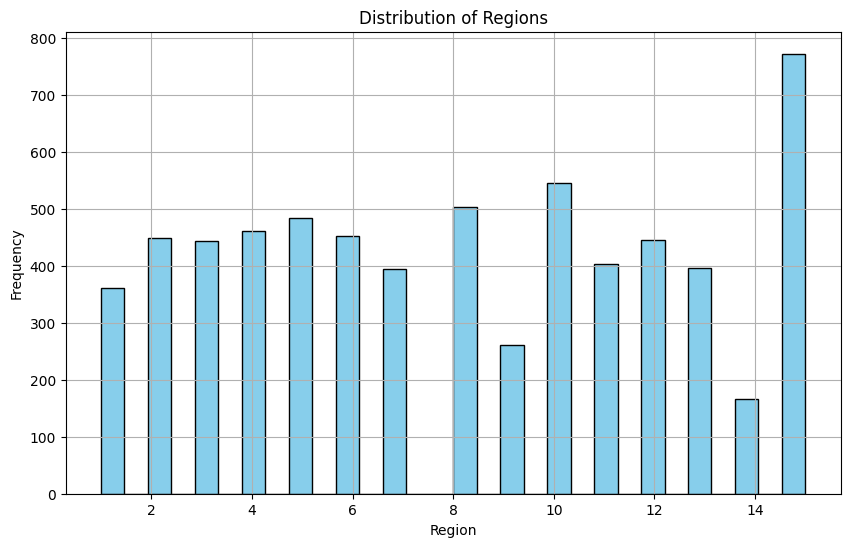

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_region['Region_ID'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Regions')
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
from sklearn.preprocessing import LabelEncoder

class RegionDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, encoder=None, fit_encoder=False):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        
        if encoder is None:
            self.encoder = LabelEncoder()
        else:
            self.encoder = encoder
        
        if fit_encoder:
            self.encoder.fit(self.df['Region_ID'])
        
        self.df['Region_ID'] = self.encoder.transform(self.df['Region_ID'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.iloc[idx, 0])
        region = self.df.iloc[idx, 5]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, region


In [7]:
import torch
import torch.nn as nn
import timm  # make sure `timm` is installed

In [8]:
class EfficientNetRegionClassifier(nn.Module):
    def __init__(self, num_classes, backbone='efficientnet_b3'):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0)
        in_features = self.backbone.num_features
        
        self.classifier = nn.Sequential(
        nn.Linear(in_features, 2048),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )



    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)


In [9]:
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = LabelEncoder()

train_dataset = RegionDataset("../labels_train_updated.csv", '../images_train/images_train',
                              transform=transform, encoder=encoder, fit_encoder=True)

val_dataset = RegionDataset("../labels_val_updated.csv", "../images_val",
                            transform=val_transform, encoder=encoder, fit_encoder=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = len(encoder.classes_)


In [11]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    model.train()
    return 100 * correct / total


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"✅ Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if (epoch + 1) % 5 == 0:
            val_acc = evaluate_model(model, val_loader, device)
            print(f"📊 Validation Accuracy after Epoch {epoch+1}: {val_acc:.2f}%")


In [13]:
import torch

if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current Device:", torch.cuda.current_device())
else:
    print("❌ CUDA is not available. Using CPU.")


✅ CUDA is available!
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
Number of GPUs: 1
Current Device: 0


In [14]:
model = EfficientNetRegionClassifier(num_classes, backbone='efficientnet_b0')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=30)
final_acc = evaluate_model(model, val_loader, device)
print(f"🏁 Final Validation Accuracy: {final_acc:.2f}%")


Epoch 1/30: 100%|██████████| 205/205 [01:19<00:00,  2.59it/s]


✅ Epoch 1, Loss: 2.0420


Epoch 2/30: 100%|██████████| 205/205 [01:17<00:00,  2.66it/s]


✅ Epoch 2, Loss: 1.1928


Epoch 3/30: 100%|██████████| 205/205 [01:16<00:00,  2.66it/s]


✅ Epoch 3, Loss: 0.7364


Epoch 4/30: 100%|██████████| 205/205 [01:17<00:00,  2.65it/s]


✅ Epoch 4, Loss: 0.5149


Epoch 5/30: 100%|██████████| 205/205 [01:17<00:00,  2.65it/s]


✅ Epoch 5, Loss: 0.3877
📊 Validation Accuracy after Epoch 5: 72.63%


Epoch 6/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 6, Loss: 0.3252


Epoch 7/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 7, Loss: 0.2360


Epoch 8/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 8, Loss: 0.1994


Epoch 9/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 9, Loss: 0.1945


Epoch 10/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 10, Loss: 0.1730
📊 Validation Accuracy after Epoch 10: 80.22%


Epoch 11/30: 100%|██████████| 205/205 [01:16<00:00,  2.67it/s]


✅ Epoch 11, Loss: 0.1625


Epoch 12/30: 100%|██████████| 205/205 [01:16<00:00,  2.67it/s]


✅ Epoch 12, Loss: 0.1438


Epoch 13/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 13, Loss: 0.1384


Epoch 14/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 14, Loss: 0.1273


Epoch 15/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 15, Loss: 0.1165
📊 Validation Accuracy after Epoch 15: 82.38%


Epoch 16/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 16, Loss: 0.1101


Epoch 17/30: 100%|██████████| 205/205 [01:16<00:00,  2.69it/s]


✅ Epoch 17, Loss: 0.1299


Epoch 18/30: 100%|██████████| 205/205 [01:16<00:00,  2.69it/s]


✅ Epoch 18, Loss: 0.0980


Epoch 19/30: 100%|██████████| 205/205 [01:16<00:00,  2.69it/s]


✅ Epoch 19, Loss: 0.0845


Epoch 20/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 20, Loss: 0.1059
📊 Validation Accuracy after Epoch 20: 79.40%


Epoch 21/30: 100%|██████████| 205/205 [01:16<00:00,  2.67it/s]


✅ Epoch 21, Loss: 0.0900


Epoch 22/30: 100%|██████████| 205/205 [01:16<00:00,  2.67it/s]


✅ Epoch 22, Loss: 0.0977


Epoch 23/30: 100%|██████████| 205/205 [01:16<00:00,  2.66it/s]


✅ Epoch 23, Loss: 0.0669


Epoch 24/30: 100%|██████████| 205/205 [01:16<00:00,  2.68it/s]


✅ Epoch 24, Loss: 0.0951


Epoch 25/30:  25%|██▍       | 51/205 [00:20<01:00,  2.53it/s]


KeyboardInterrupt: 

In [15]:
evaluate_model(model, val_loader, device)


78.04878048780488